In [25]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as skl_preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from statistics import mode
import random
from math import log2
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def preprocess_data(data):
    relevant_data = data[["release_speed", "release_pos_x", "release_pos_z", "release_pos_y", "release_spin_rate", "vx0", "vy0", "vz0", "ax", "ay", "az", "pfx_x", "pfx_z", "spin_axis", "pitch_number", "zone", "p_throws", "balls", "strikes", "pitch_type"]]
    
    relevant_data = relevant_data.dropna()
    relevant_data['p_throws'] = (relevant_data['p_throws'] == 'R').astype(int)
    
    return relevant_data

In [3]:
def score(predictions, actual):
    """
    Returns the f1 score, precision, and recall of a prediction
    
    predictions: list of predictions
    actual: list of actual outcomes
    """
    
    tp, tn, fp, fn = 0, 0, 0, 0
    for prediction, actual in zip(predictions, actual):
        if prediction == actual:
            if prediction == 1:
                tp += 1
            else:
                tn += 1
        else:
            if prediction == 1:
                fp += 1
            else:
                fn += 1
    
    if tp == 0:
        return 0
                
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    f1_score = 2 * precision * recall / (precision + recall)
    
    return f1_score, precision, recall

In [8]:
raw_input_data = pd.read_csv('data/Statcast_2021.csv')
data = preprocess_data(raw_input_data)
data.head()

,release_speed,release_pos_x,release_pos_z,release_pos_y,release_spin_rate,vx0,vy0,vz0,ax,ay,az,pfx_x,pfx_z,spin_axis,pitch_number,zone,p_throws,balls,strikes,pitch_type
0,92.3,1.40,6.80,54.03,2330.0,-6.833043,-134.166485,-7.361843,9.708393,26.562803,-14.083224,0.69,1.38,148.0,4,1.0,0,1,2,FF
1,80.6,1.60,6.64,54.15,2254.0,-3.700232,-117.430885,-3.266842,-6.531123,19.793390,-27.369114,-0.77,0.48,315.0,3,4.0,0,1,1,SL
2,75.5,1.46,6.88,54.34,1940.0,-1.977183,-109.901781,-1.155694,-4.872924,20.602334,-36.262184,-0.65,-0.51,328.0,2,5.0,0,1,0,CU
3,75.0,1.53,6.83,54.61,2017.0,2.375830,-109.205830,2.277617,-5.902656,19.427562,-38.284747,-0.69,-0.69,330.0,1,12.0,0,0,0,CU
4,91.2,1.49,6.66,54.15,2281.0,-5.868477,-132.500539,-6.486796,8.700586,30.117690,-15.941174,0.63,1.28,143.0,2,4.0,0,1,0,FF


In [11]:
model = RandomForestClassifier(n_estimators=10, criterion="entropy", max_depth=10)
ground_truth = data.iloc[:, -1]
classes = pd.unique(ground_truth)

scores = {}
k = 10
for i in range(k):
    test_data = data.iloc[i * len(data) // k: (i + 1) * len(data) // k]
    train_data = pd.concat([data.iloc[0:i * len(data) // k], data.iloc[(i + 1) * len(data) // k:]])

    gt_data = []
    for i, item in train_data.iloc[:, -1].items():
        gt_data.append(np.where(classes == item)[0][0])

    model.fit(train_data.iloc[:, :-1], gt_data)

    predictions = model.predict(test_data.drop(['pitch_type'], axis=1))

    score = metrics.classification_report(test_data['pitch_type'], [classes[p] for p in predictions], digits=4, output_dict=True)
    average = score["weighted avg"]
    scores[i] = average


    print(f"Scores for Fold {i}: {average}")

mean_validated_scores = Counter()
for score in scores.values():
    mean_validated_scores["precision"] += score["precision"]
    mean_validated_scores["recall"] += score["recall"]
    mean_validated_scores["f1-score"] += score["f1-score"]
    
for key in mean_validated_scores.keys():
    mean_validated_scores[key] /= len(scores)
    
print(mean_validated_scores)
    
gt_data = []
for i, item in data.iloc[:, -1].items():
    gt_data.append(np.where(classes == item)[0][0])

C:\Users\sas02\Schoolwork\MachineLearning\mlvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sas02\Schoolwork\MachineLearning\mlvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sas02\Schoolwork\MachineLearning\mlvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Scores for Fold 709849: {'precision': 0.8523890962877192, 'recall': 0.8549842958603322, 'f1-score': 0.8463017077607186, 'support': 70682}


C:\Users\sas02\Schoolwork\MachineLearning\mlvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sas02\Schoolwork\MachineLearning\mlvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sas02\Schoolwork\MachineLearning\mlvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Scores for Fold 709849: {'precision': 0.8532368093143818, 'recall': 0.8558352079000608, 'f1-score': 0.8468844348837479, 'support': 70683}
Scores for Fold 709849: {'precision': 0.8523669767457744, 'recall': 0.852183016892561, 'f1-score': 0.8437592330075708, 'support': 70682}
Scores for Fold 709849: {'precision': 0.8636853370150417, 'recall': 0.8649321619059746, 'f1-score': 0.8576184813374292, 'support': 70683}
Scores for Fold 709849: {'precision': 0.8600556098119362, 'recall': 0.8601219529448382, 'f1-score': 0.8500338343302847, 'support': 70683}


C:\Users\sas02\Schoolwork\MachineLearning\mlvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sas02\Schoolwork\MachineLearning\mlvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sas02\Schoolwork\MachineLearning\mlvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Scores for Fold 709849: {'precision': 0.8529128263825778, 'recall': 0.8575026173566113, 'f1-score': 0.8485016241891605, 'support': 70682}
Scores for Fold 709849: {'precision': 0.8418727987938973, 'recall': 0.848181316582488, 'f1-score': 0.8367773532317352, 'support': 70683}
Scores for Fold 709849: {'precision': 0.8577506897494513, 'recall': 0.8613791347160522, 'f1-score': 0.8530333463246983, 'support': 70682}
Scores for Fold 709849: {'precision': 0.8440715133380492, 'recall': 0.8425646902366906, 'f1-score': 0.8302710106462505, 'support': 70683}


C:\Users\sas02\Schoolwork\MachineLearning\mlvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sas02\Schoolwork\MachineLearning\mlvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sas02\Schoolwork\MachineLearning\mlvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

Scores for Fold 638655: {'precision': 0.8393798521938594, 'recall': 0.8420270786469165, 'f1-score': 0.82822871713436, 'support': 70683}
Counter({'accuracy': 0.8422958844418036, 'precision': 0.8417256827659543, 'f1-score': 0.8292498638903052})


In [20]:
nsamples = 10
model.fit(data.iloc[:, :-1], gt_data)
for i in range(nsamples):
    prediction = model.predict(np.array(data.iloc[i].drop(['pitch_type'])).reshape(1, -1))
    actual = data.iloc[i, -1]

    prediction = classes[prediction]
    print(f"Sample {i} - Prediciton: {prediction}, Actual: {actual}")

Sample 0 - Prediciton: ['FF'], Actual: FF
Sample 1 - Prediciton: ['SL'], Actual: SL
Sample 2 - Prediciton: ['CU'], Actual: CU
Sample 3 - Prediciton: ['CU'], Actual: CU
Sample 4 - Prediciton: ['FF'], Actual: FF
Sample 5 - Prediciton: ['FF'], Actual: FF
Sample 6 - Prediciton: ['SL'], Actual: SL
Sample 7 - Prediciton: ['SL'], Actual: SL
Sample 8 - Prediciton: ['FF'], Actual: FF
Sample 9 - Prediciton: ['SI'], Actual: SI


C:\Users\sas02\Schoolwork\MachineLearning\mlvenv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\sas02\Schoolwork\MachineLearning\mlvenv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\sas02\Schoolwork\MachineLearning\mlvenv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\sas02\Schoolwork\MachineLearning\mlvenv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\sas02\Schoolwork\MachineLearning\mlvenv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but RandomFore

array([[<AxesSubplot: title={'center': 'release_speed'}>],
       [<AxesSubplot: title={'center': 'release_spin_rate'}>]],
      dtype=object)

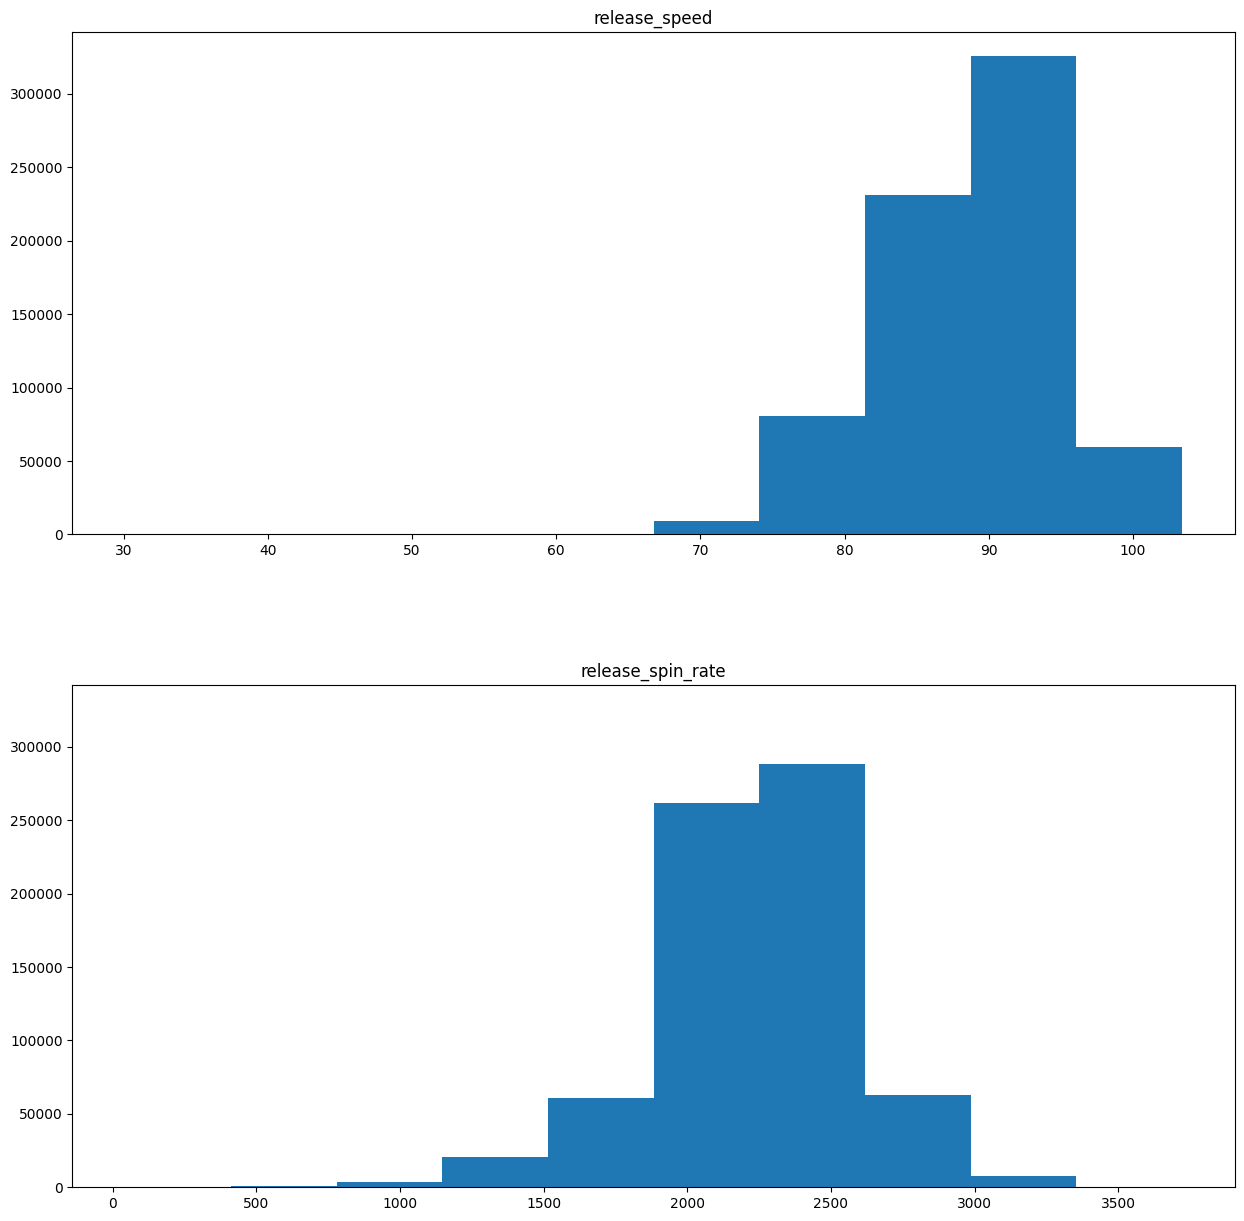

In [68]:
data.hist(column=["release_speed", "release_spin_rate"], layout=(2, 1), figsize=[15, 15], grid=False, sharey=True)

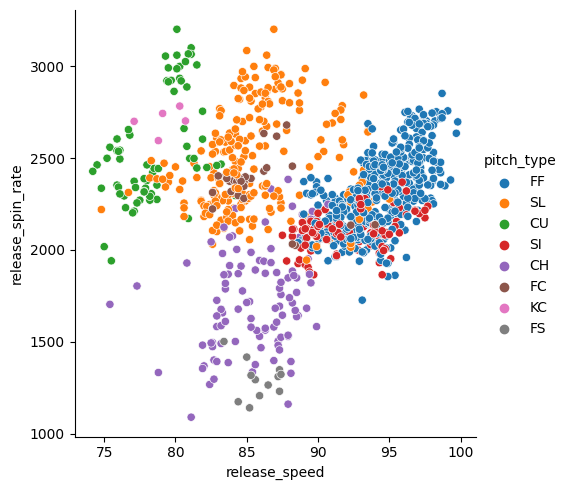

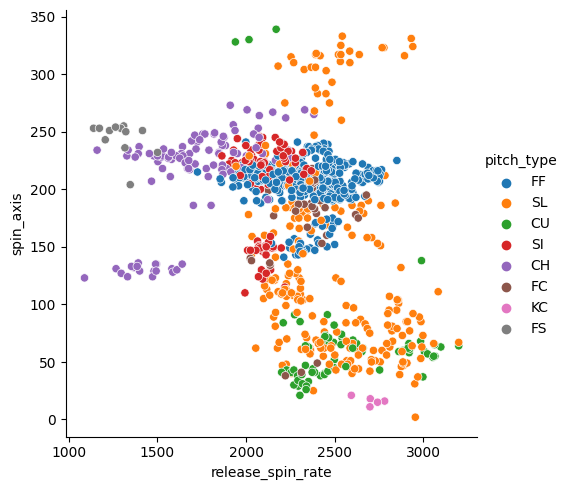

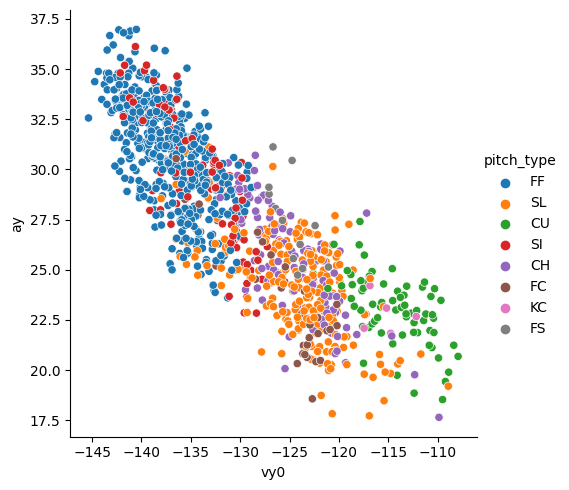

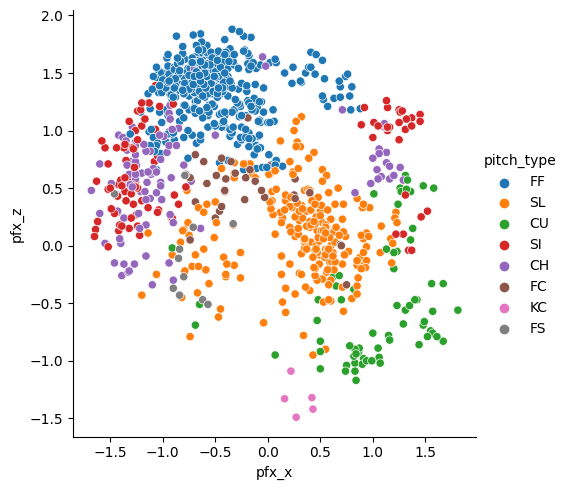

In [74]:
combinations = [('release_speed', 'release_spin_rate'), ('release_spin_rate', 'spin_axis'), ('vy0', 'ay'), ('pfx_x', 'pfx_z')]
for combo1, combo2 in combinations:
    sns.relplot(data=data.iloc[:1000, :], x=combo1, y=combo2, hue='pitch_type')
plt.show()

In [77]:
test_data = preprocess_data(pd.read_csv('data/Statcast_2020.csv'))

predictions = model.predict(test_data.drop(['pitch_type'], axis=1))

score = metrics.classification_report(test_data['pitch_type'], [classes[p] for p in predictions], digits=4, output_dict=True)
average = score["weighted avg"]
print(average)

C:\Users\sas02\Schoolwork\MachineLearning\mlvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sas02\Schoolwork\MachineLearning\mlvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'precision': 0.8245341130960478, 'recall': 0.8265284127650402, 'f1-score': 0.814023986335317, 'support': 264441}


C:\Users\sas02\Schoolwork\MachineLearning\mlvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
